# **Image analysis in the *frequency domain***
Fundamentally, images are considered to be an aggregation sinusoids of signals. In an attempt to understand heat diffusion, *John Baptiste Joseph-Fourier* developed a mathematical method for *decomposing periodic functions into a linear combination of sines and cosines functions.* This mathematical formulation has since been extended to different functions (periodic and non-periodic alike) leading to important development in image processing, signal processing and other disciplines. 

In this notebook, we will consider the fundamental ideas of processing images in the fourier domain (popularly called the frequency domain) using the fourier transforms. In general, we will:
- Verify the invertibiility of the Fast Fourier Transform (FFT) applied to images, 
- Compare the effect of some of the Low-pass and High filters in the frequency domain, 
- Perform image sharpening in the frequency, 
- Perform noise reduction and image restoration (Noth filter and Wiener filter)

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20191205112135/Capture33555.png" alt = "Main frequency domain filters">

Source: [GeeksforGeeks](https://www.geeksforgeeks.org/frequency-domain-filters-and-its-types/)


#### Workspace utilities

In [ ]:
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
from numpy.fft import fftshift, fft2, ifft2, ifftshift
from skimage import io
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **01. Verification of the invertibility of the FFT**
In this session, we will prove the invertibility of the FFT on a given image following the mathematical expression: *I = IFFT(FFT(I))*, *I* is considered as our input image.



###### Load image into workspace

Text(0.5, 1.0, 'Greyscale image')

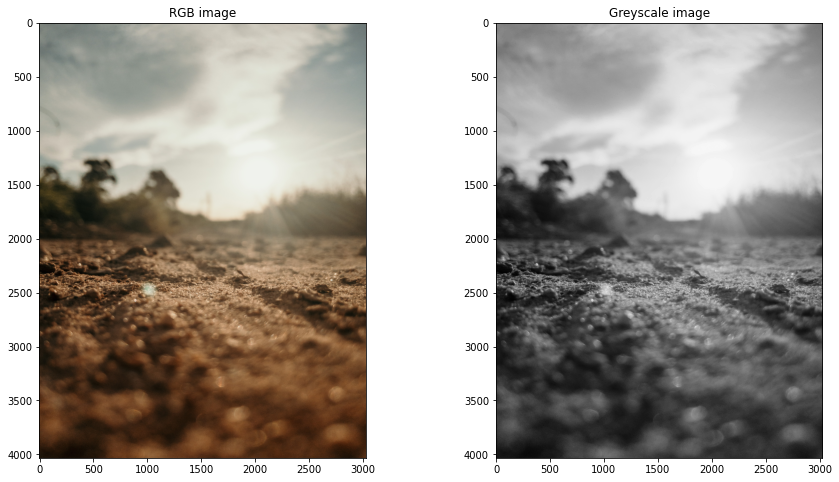

In [ ]:
img_bgr = cv2.imread("/content/drive/MyDrive/UBS/Computer Vision/Data/freq_img.jpg")
b, g, r = cv2.split(img_bgr)
img_rgb = cv2.merge([r, g, b])

img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

fig, axs = plt.subplots(1, 2, figsize=(15,8))
axs[0].imshow(img_rgb)
axs[0].set_title("RGB image")

axs[1].imshow(img_gray, cmap = 'gray')
axs[1].set_title("Greyscale image")

Text(0.5, 1.0, 'FFT Transform of image')

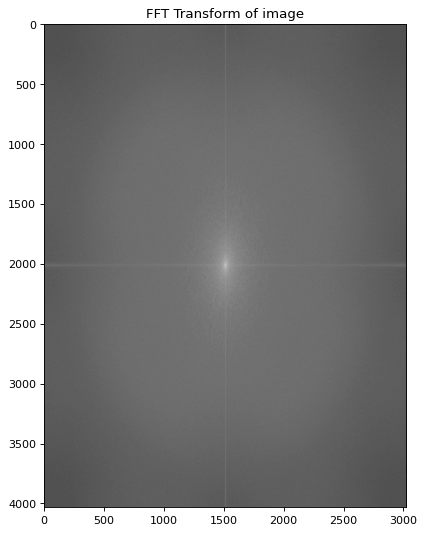

In [ ]:
# F_shift
img_fourier = fftshift(fft2(img_gray))
abs_fourier = abs(img_fourier)
plt.figure(num=None, figsize=(15,8), dpi=80)
plt.imshow(np.log(abs_fourier), cmap= 'gray')
plt.title("FFT Transform of image")

The FFT transform of our image shows two clear distortions of our image -- vertical and horizontal representing the sharp horizontal and vertical elements of the image. Now we would mask our image

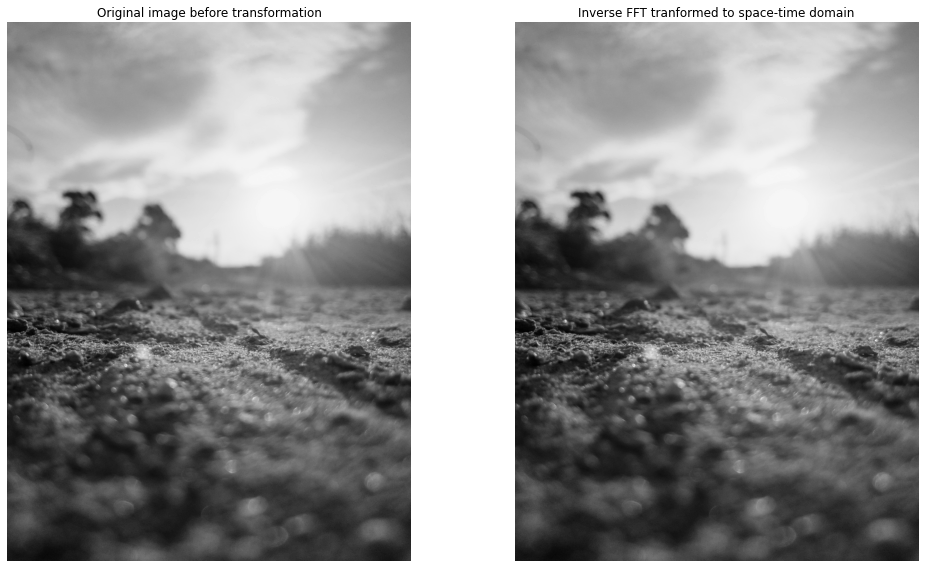

In [ ]:
gray_fft = fftshift(fft2((img_gray)))
inverse_rgb = np.abs(ifft2(ifftshift(gray_fft)))

fig, ax = plt.subplots(1, 2, figsize=(15,8))

ax[0].imshow(img_gray, cmap = 'gray')
ax[0].set_title('Original image before transformation')
ax[0].set_axis_off()
    
ax[1].imshow(inverse_rgb, cmap = 'gray')
ax[1].set_title('Inverse FFT tranformed to space-time domain')
ax[1].set_axis_off()
    
fig.tight_layout()

In [ ]:
def invertible_rgb(image):
    transformed_channels = []

    for i in range(3):
        rgb_fft = np.fft.fftshift(np.fft.fft2((image[:, :, i])))
        transformed_channels.append(abs(np.fft.ifft2(rgb_fft)))
    
    final_image = np.dstack([transformed_channels[0].astype(int), 
                             transformed_channels[1].astype(int), 
                             transformed_channels[2].astype(int)])
    
    fig, ax = plt.subplots(1, 2, figsize=(15,8))
    ax[0].imshow(image)
    ax[0].set_title('Original image before transformation')
    ax[0].set_axis_off()
    
    ax[1].imshow(final_image)
    ax[1].set_title('Inverse FFT tranformed to space-time domain')
    ax[1].set_axis_off()
    
    fig.tight_layout()

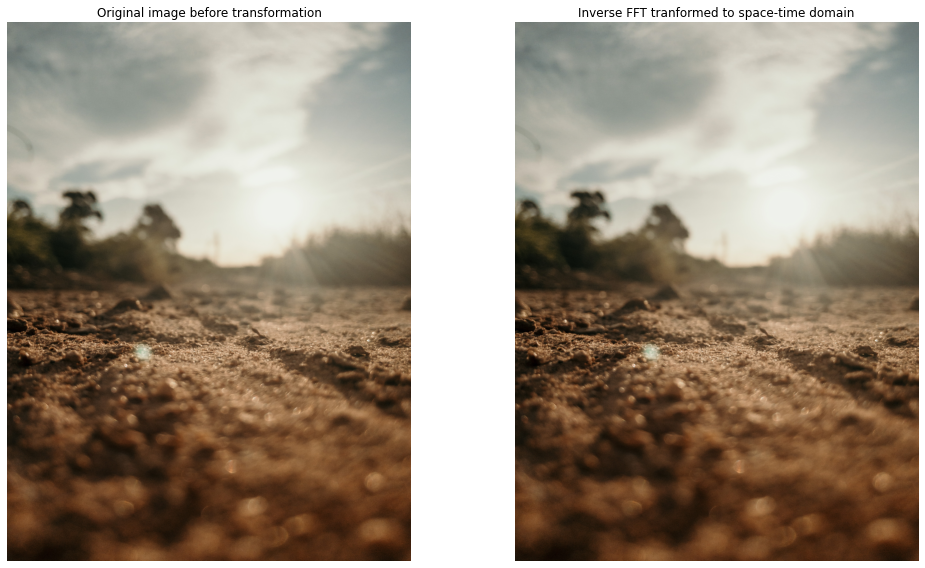

In [ ]:
invertible_rgb(img_rgb)

The graphical display above shows the invertibility of the Fourier transform, which is the ability of the FFT function to recover the original image after transforming to (and / or filtering in) the fourier/ frequency domain. 
*I = IFFT(FFT(I))*, *I* 

#### **02. Comparing the effect of the *Diameter* on Low pass filters in the frequency domain**
In the frequency domain, image signals are represented as the amplitude and frequencies of signals. These signals can either be high frequency or low frequency and represent significant portion of the image, in some cases they might be the noisy parts and signals irrelevant to our analysis. 
Low pass filters, as the name implies, only passes low frequency components of the image signals. That is, it removes/ reject the high frequency components and keeps the low frequency components. Generally, they are used for smoothing images.

The process of low pass filtering is given by the formulation:
- G(u, v) = H(u, v) . F(u, v)
where F(u, v) is the Fourier Transform of original image and H(u, v) is the Fourier Transform of filtering mask. 

In this session, we see an example of the main low pass filters used for filtering images in the frequency domain: 
- Ideal filter,
- Gaussian filter, and 
- Butterworth filter


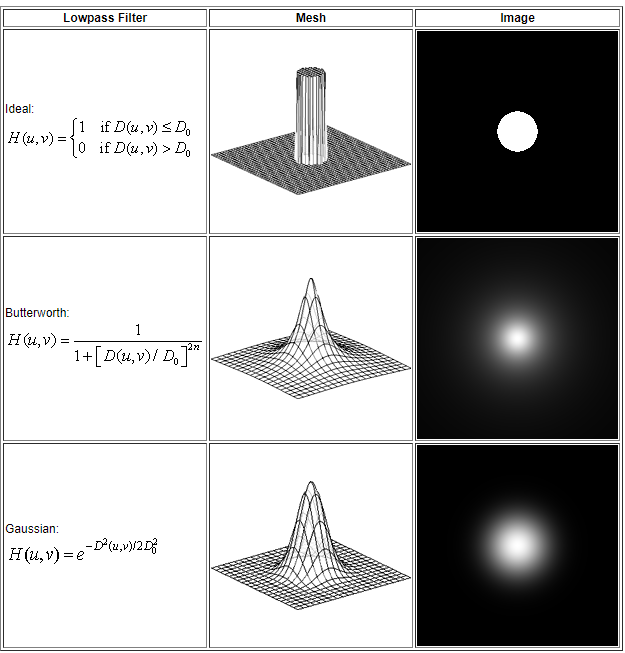

Reference: https://www.geeksforgeeks.org/frequency-domain-filters-and-its-types/

###### Ideal filter

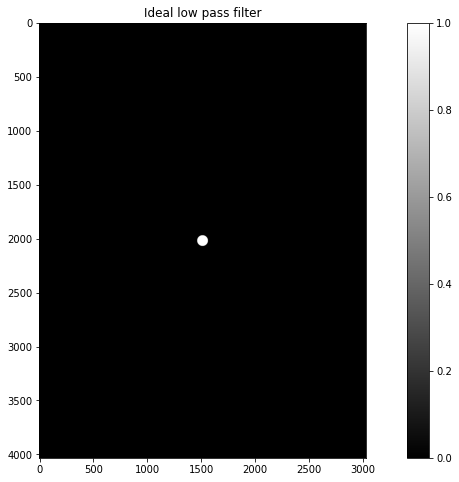

In [ ]:
shape = img_gray.shape[:2]

# create the ideal filter for LPF and HPF
def ideal_filter(shape, diameter):
  assert len(shape) == 2
  mask = np.zeros(shape,dtype=np.bool)
  center = np.array(mask.shape)/2.0

  for iy in range(shape[0]):
    for ix in range(shape[1]):
      mask[iy,ix] = (iy- center[0])**2 + (ix - center[1])**2 < diameter **2
  return(mask)


low_pass_filter = ideal_filter(shape=img_gray.shape[:2], diameter=50)

plt.figure(figsize=(15, 8))
plt.imshow(low_pass_filter,cmap="gray")
plt.title("Ideal low pass filter")
plt.colorbar()
plt.show()

In [ ]:
def filter_image(filter, fft_img):
  filtered = np.zeros(fft_img.shape[:2], dtype=complex)
  filtered[filter] = fft_img[filter]
  return(filtered)

In [ ]:
def plot_fourier(fft_pre, fft_post, img_pre, img_post):
  fig, axs = plt.subplots(1, 4, figsize = (25, 12))
  axs[0].imshow(fft_pre, cmap = 'gray')
  axs[0].set_title("FFT before filtering")
  axs[1].imshow(fft_post, cmap = 'gray')
  axs[1].set_title("FFT after filtering")
  axs[2].imshow(img_pre, cmap = 'gray')
  axs[2].set_title("Image before filtering")
  axs[3].imshow(img_post, cmap = 'gray')
  axs[3].set_title("Image after filtering")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


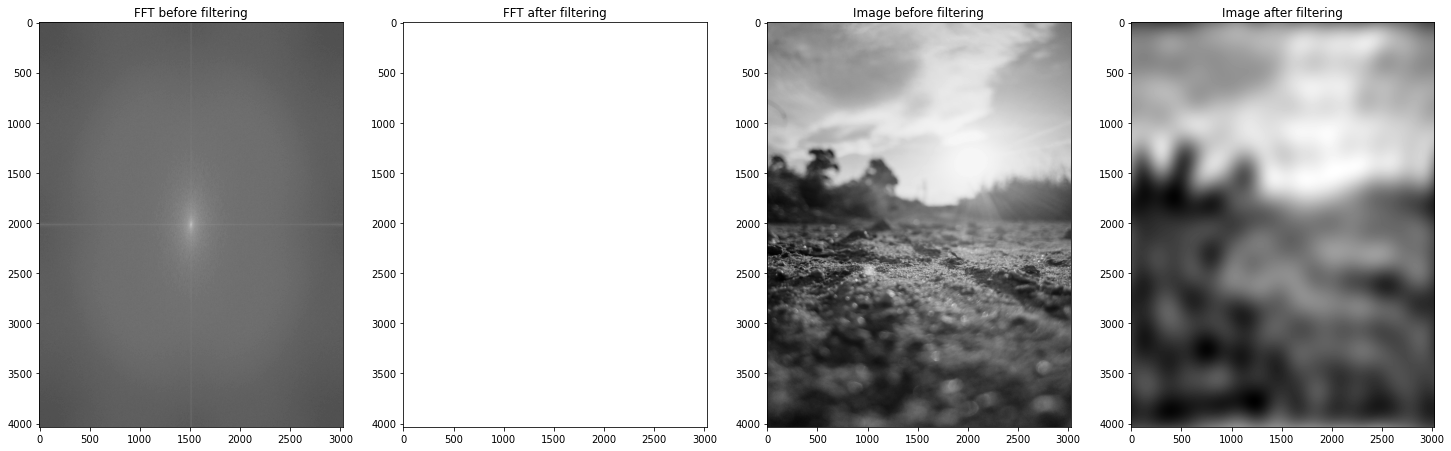

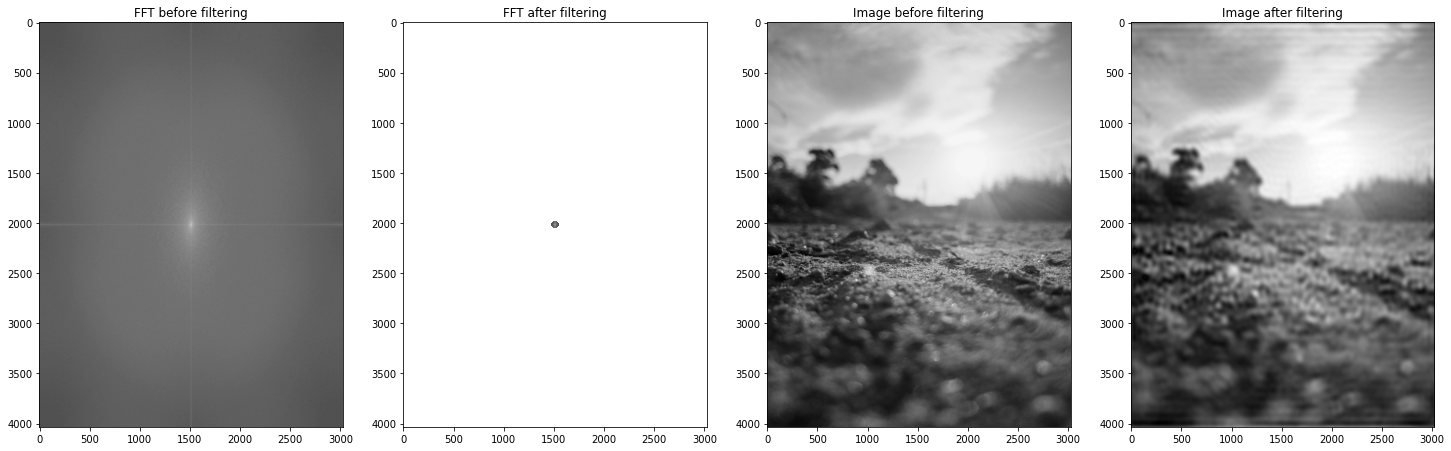

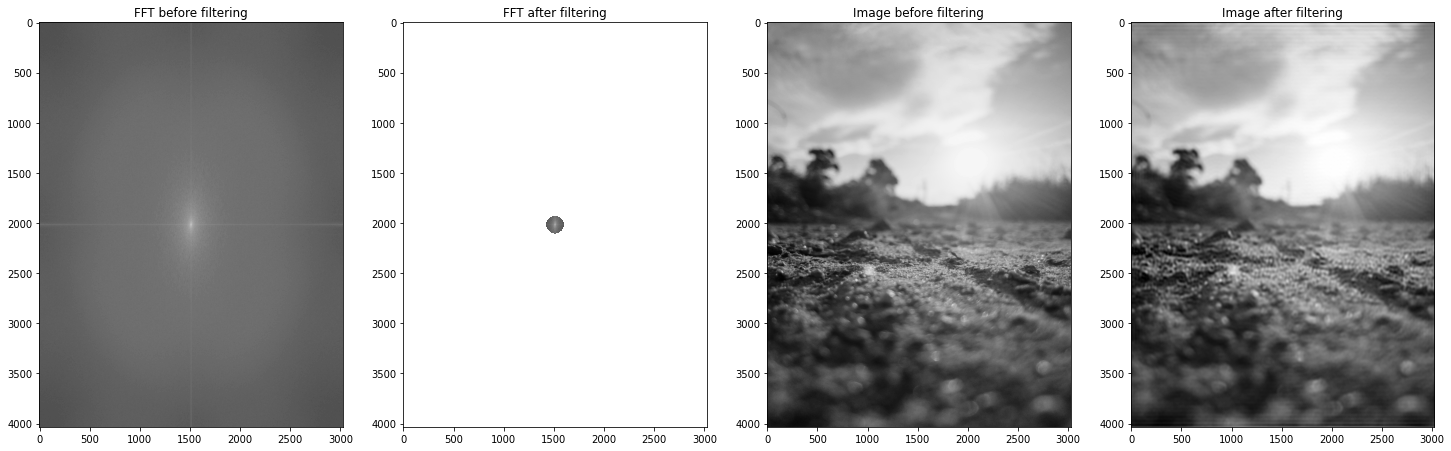

In [ ]:
diameter_values = [10, 50, 100]

for d in diameter_values:
  lpf = ideal_filter(shape=img_gray.shape[:2], diameter=d)
  fft_img = fftshift(fft2(img_gray))
  abs_fft_img = 20*np.log(np.abs(fft_img))
  filter_fft_init = filter_image(lpf, fft_img)
  filter_fft = np.abs(np.array(filter_fft_init))
  abs_filter_fft = 20*np.log(filter_fft)
  # obtain the inverse FFT
  tranformed_img = np.array(np.abs(ifft2(ifftshift(filter_fft_init))))
  plot_fourier(abs_fft_img, abs_filter_fft, img_gray, tranformed_img)

###### Gaussian filter

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


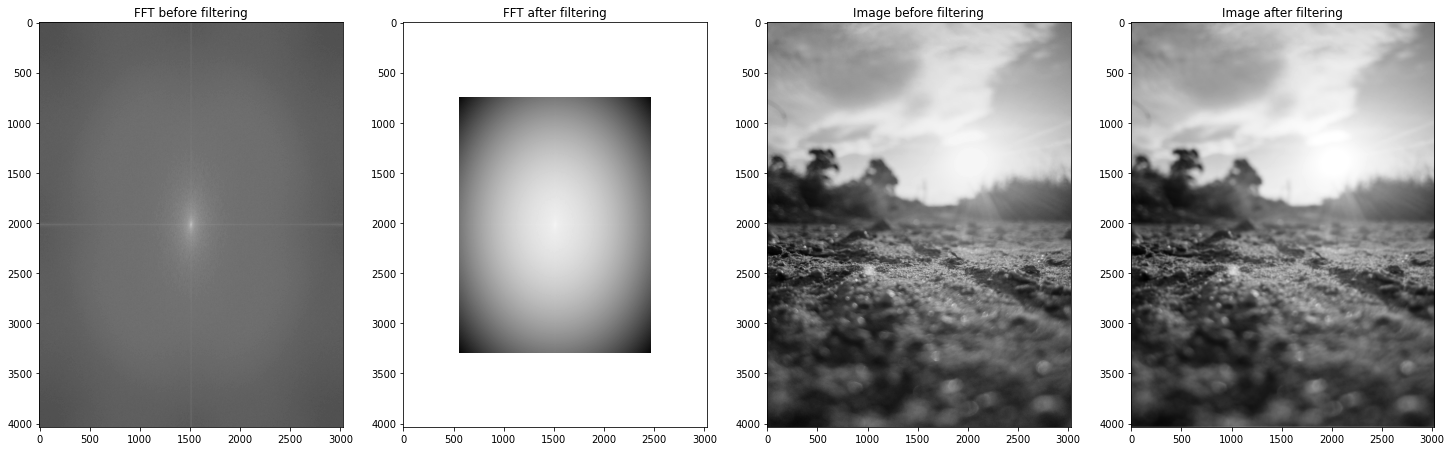

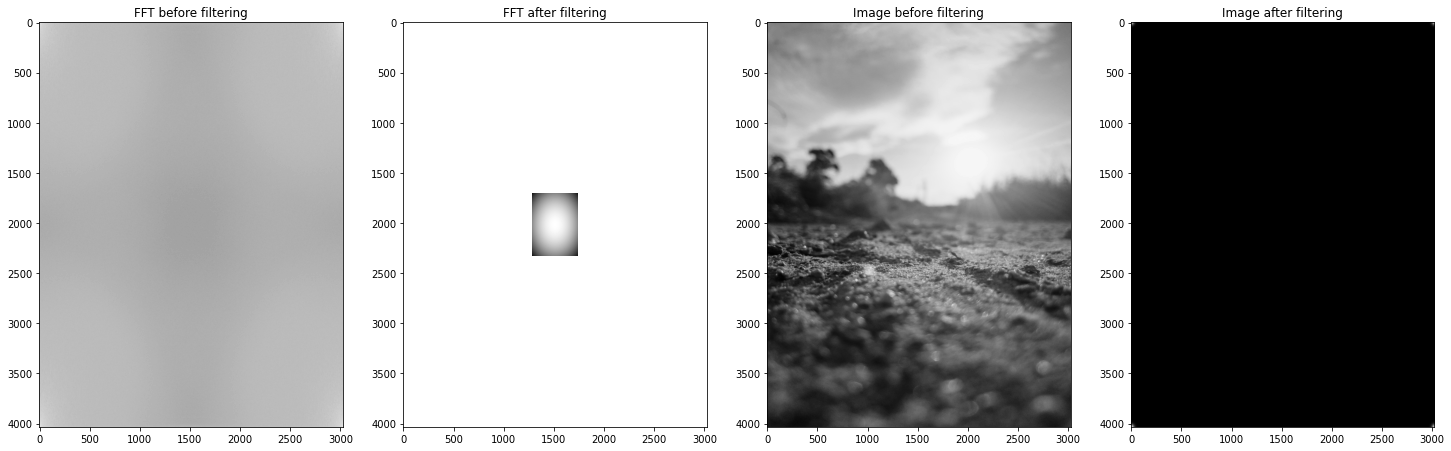

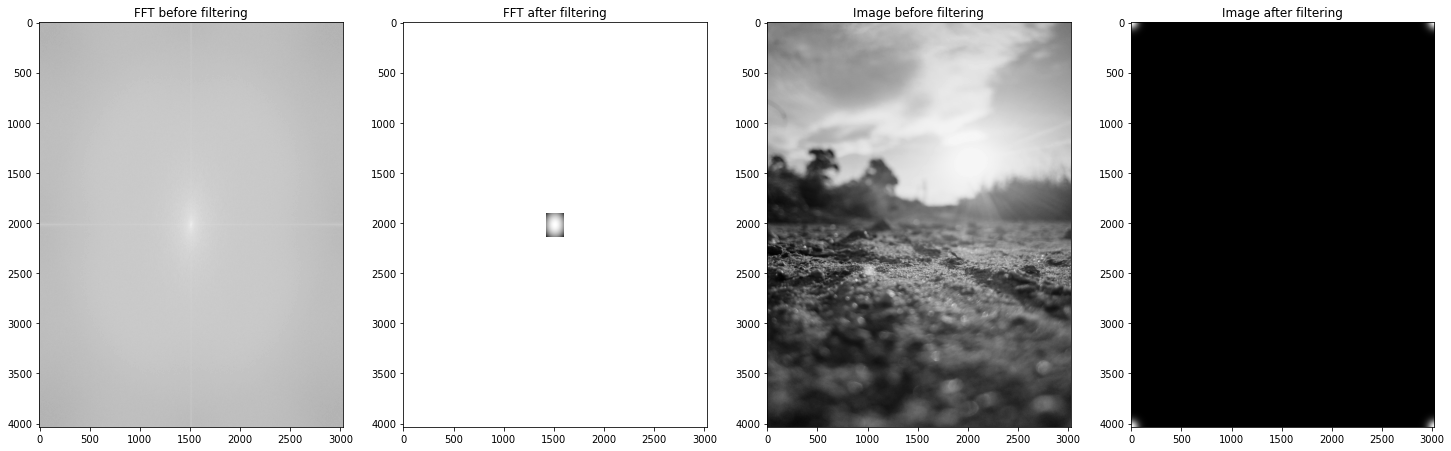

In [ ]:
from scipy.ndimage import fourier_gaussian

diameter_values = [5, 20, 50]
img_fft = fft2(img_gray)

for d in diameter_values:
  gaussian_filt = fourier_gaussian(img_fft, sigma = d)
  filtered_img = ifft2(gaussian_filt)
  img_fft = 20*np.log(np.abs(fftshift(img_fft)))
  gaussian_filt = 20*np.log(np.abs(fftshift(gaussian_filt)))
  gaussian_img = np.abs(filtered_img)
  plot_fourier(img_fft, gaussian_filt, img_gray, gaussian_img)

#### **03. Comparing the effect of the *Diameter* on High pass filters in the frequency domain**
High pass filter removes the low frequency components that means it keeps high frequency components. It is used for sharpening the image. It is used to sharpen the image by attenuating low frequency components and preserving high frequency components.
Mechanism of high pass filtering in frequency domain is given by:

H(u, v) = 1 - H'(u, v)
where H(u, v) is the Fourier Transform of high pass filtering
and H'(u, v) is the Fourier Transform of low pass filtering 

Reference: https://www.geeksforgeeks.org/frequency-domain-filters-and-its-types/


###### Ideal filter

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


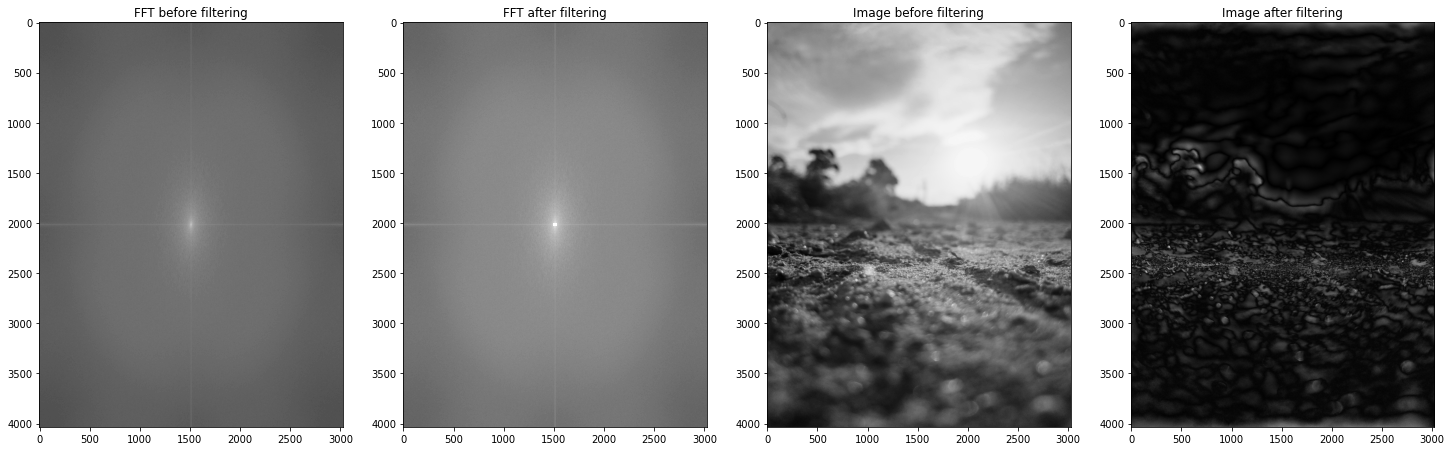

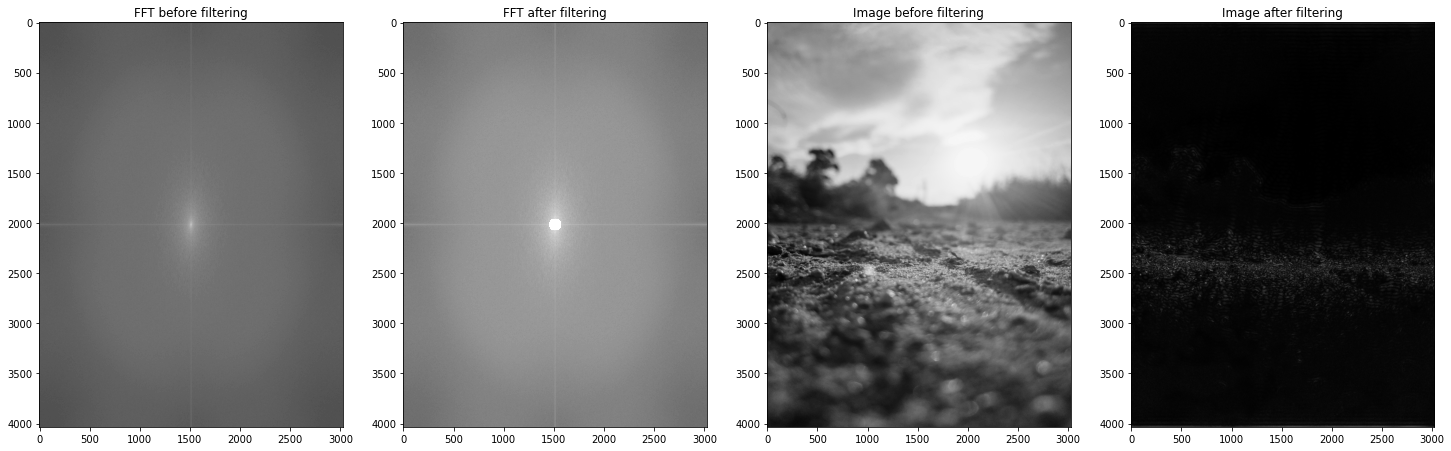

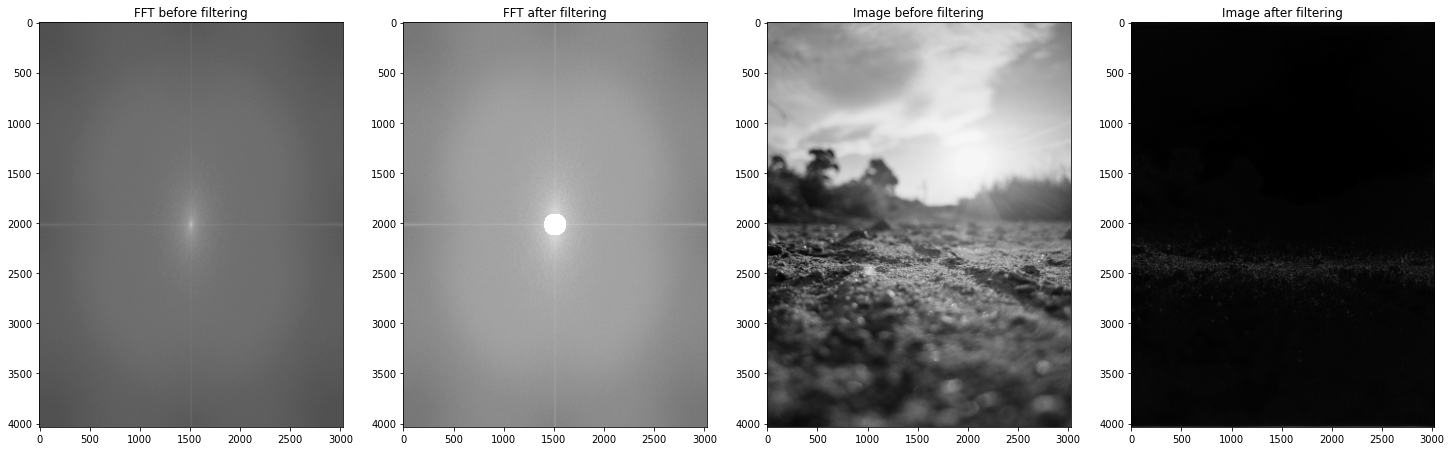

In [ ]:
high_pass_filter  = ~low_pass_filter
diameter_values = [10, 50, 100]

for d in diameter_values:
  low_pass_filter = ideal_filter(shape=img_gray.shape[:2], diameter=d)
  hpf = ~low_pass_filter

  fft_img = fftshift(fft2(img_gray))
  abs_fft_img = 20*np.log(np.abs(fft_img))
  
  filter_fft_init = filter_image(hpf, fft_img)
  filter_fft = np.abs(np.array(filter_fft_init))
  abs_filter_fft = 20*np.log(filter_fft)
  # obtain the inverse FFT
  tranformed_img = np.array(np.abs(ifft2(ifftshift(filter_fft_init))))
  plot_fourier(abs_fft_img, abs_filter_fft, img_gray, tranformed_img)


###### Gaussian filters

In [ ]:
# https://hicraigchen.medium.com/digital-image-processing-using-fourier-transform-in-python-bcb49424fd82

def distance(point1,point2):
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def gaussianHP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = 1 - np.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


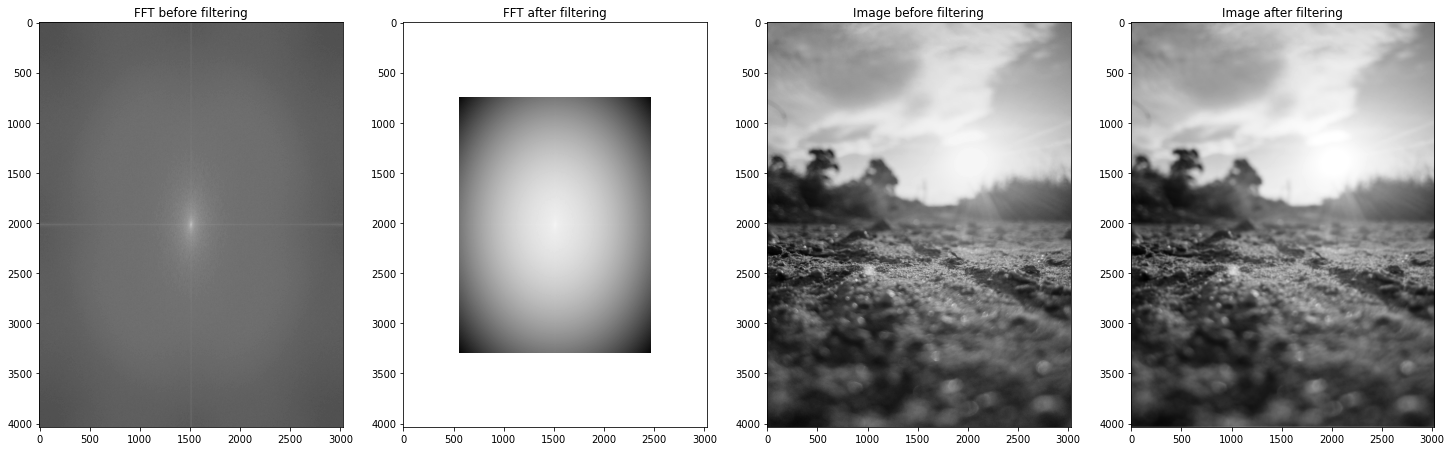

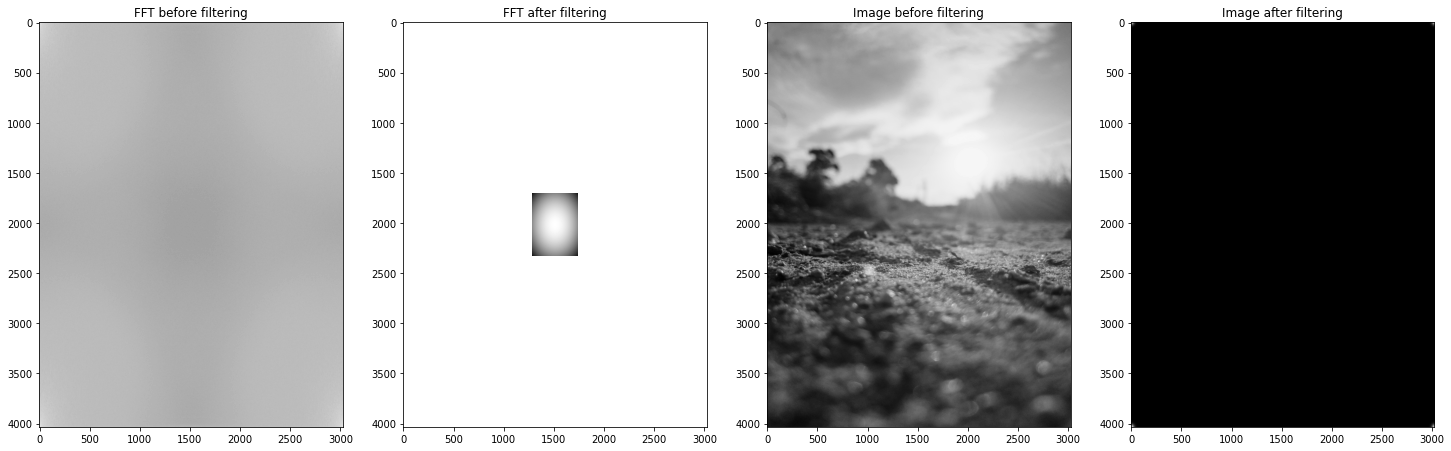

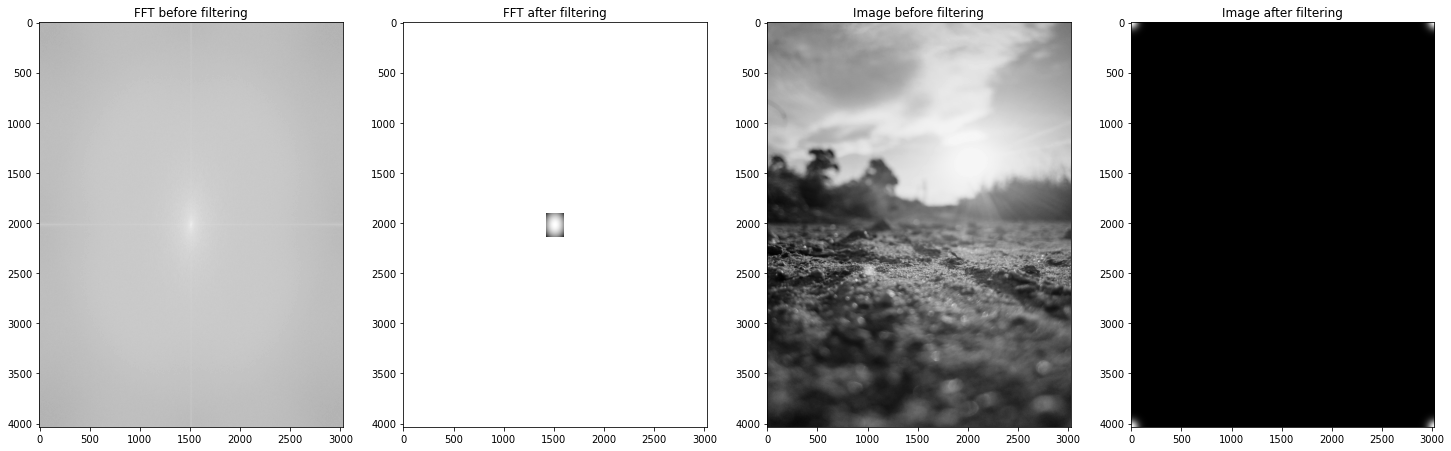

In [ ]:
from scipy.ndimage import fourier_gaussian

diameter_values = [5, 20, 50]
img_fft = fft2(img_gray)

for d in diameter_values:
  gaussian_filt = fourier_gaussian(img_fft, sigma = d)
  filtered_img = ifft2(gaussian_filt)
  img_fft = 20*np.log(np.abs(fftshift(img_fft)))
  gaussian_filt = 20*np.log(np.abs(fftshift(gaussian_filt)))
  gaussian_img = np.abs(filtered_img)
  plot_fourier(img_fft, gaussian_filt, img_gray, gaussian_img)

#### Image sharpening filtering

Low Pass


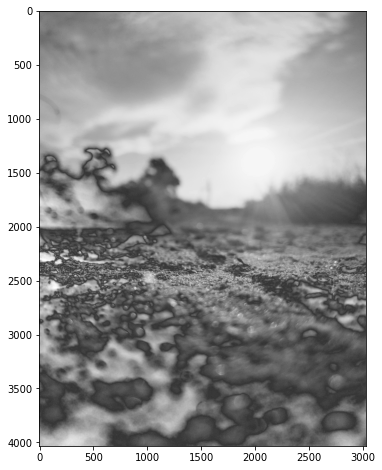

In [ ]:
#https://www.datadriveninvestor.com/2020/10/23/fourier-transform-for-image-processing-in-python-from-scratch/
#low pass filter
kernel = np.ones((10,10),np.float32)/25   
Lp = cv2.filter2D(img_gray,-1, kernel)
Lp = img_gray - Lp
print("Low Pass")
plt.figure(figsize = (15, 8))
plt.imshow(Lp, cmap='gray')


#### Notch filtering in the frequency domain
- add some periodic noise in the frequency domain and remove it with the notch filter



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0.5, 1.0, 'Filtered image')

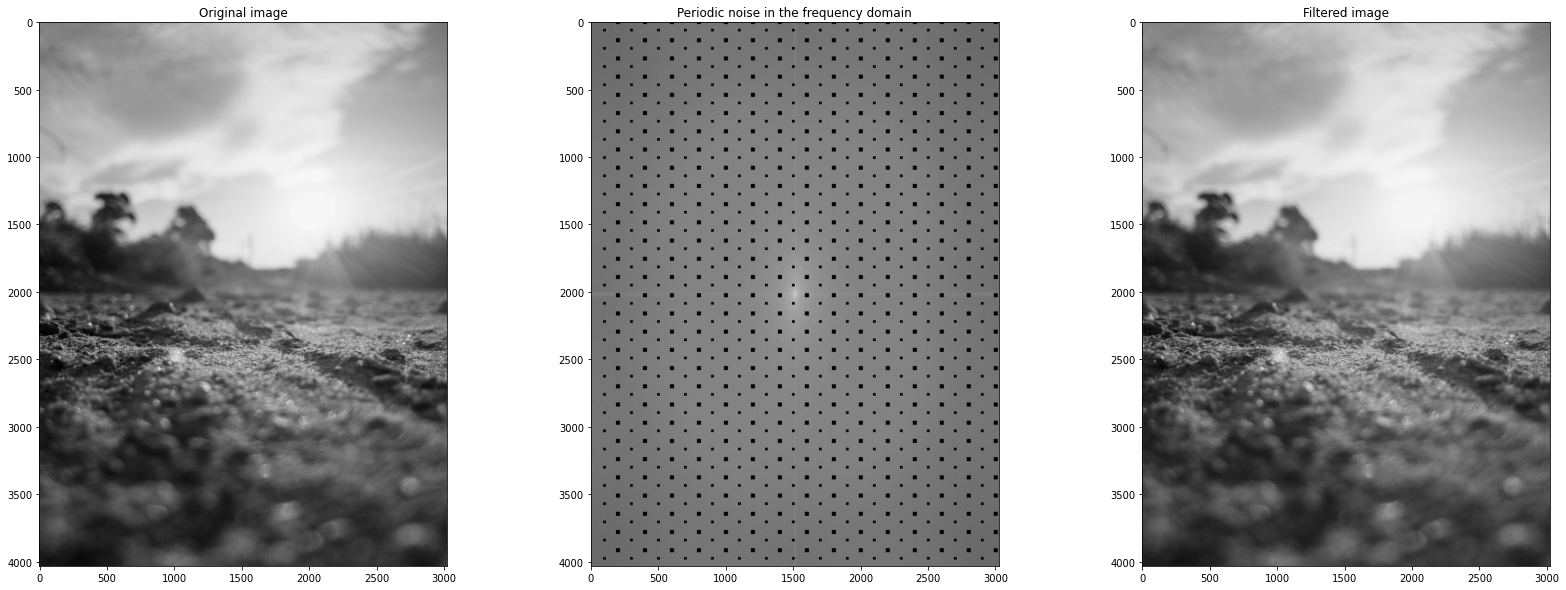

In [ ]:
#https://sandipanweb.wordpress.com/2018/07/30/some-image-processing-problems/
from scipy import fftpack
from scipy import fftpack as fp 

#im = imread('images/halftone.png')
w, h = img_gray.shape

F1 = fftpack.fft2((img_gray).astype(float))
F2 = fftpack.fftshift(F1)

# add noise
for i in range(60, w, 135):
   for j in range(100, h, 200):
     if not (i == 330 and j == 500):
        F2[i-10:i+10, j-10:j+10] = 0
for i in range(0, w, 135):
   for j in range(200, h, 200):
     if not (i == 330 and j == 500):
        F2[max(0,i-15):min(w,i+15), max(0,j-15):min(h,j+15)] = 0

fig, axs = plt.subplots(1, 3, figsize = (28, 10))

#plt.figure(figsize=(6.66,10))
axs[0].imshow(img_gray, cmap='gray')
axs[0].set_title("Original image")

axs[1].imshow( (20*np.log10( 0.1 + F2)).astype(int), cmap=plt.cm.gray)
axs[1].set_title("Periodic noise in the frequency domain")

im1 = fp.ifft2(fftpack.ifftshift(F2)).real
axs[2].imshow(im1, cmap='gray')
axs[2].set_title("Filtered image")

#### Wiener filter
- Generate noisy versions of an image using different noise models, 
- Perform noise reduction/image restoration

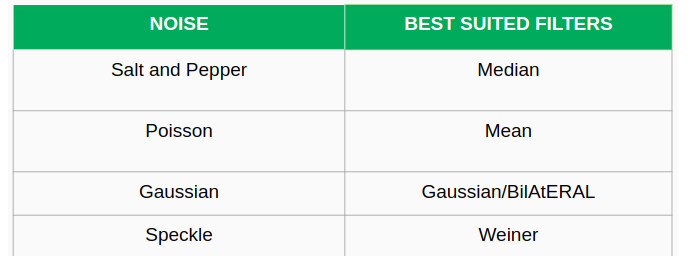

Gaussian noise removal

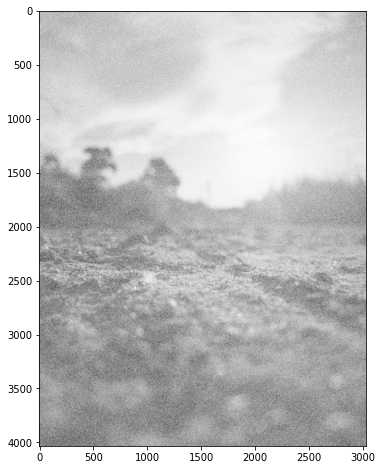

In [ ]:
# Gaussian noise
import cv2
import numpy as np

# Generate Gaussian noise
gauss = np.random.normal(0, 8, img_gray.size)

gauss = gauss.reshape(img_gray.shape[0], img_gray.shape[1]).astype('uint8')

# Add the Gaussian noise to the image
img_gauss = cv2.add(img_gray,gauss)
# Display the image
plt.figure(figsize=(15, 8))
plt.imshow(img_gauss, cmap='gray')

Text(0.5, 1.0, 'FFT Transform of image')

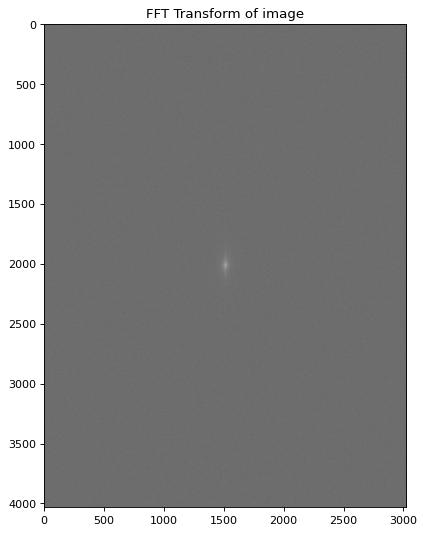

In [ ]:
# F_shift
# compute the fourier transform of the noisy image
img_fourier = fftshift(fft2(img_gauss))
abs_fourier = abs(img_fourier)

gaussian_filt = fourier_gaussian(img_fourier, sigma = 3)
filtered_img = ifft2(gaussian_filt)

plt.figure(num=None, figsize=(15,8), dpi=80)
plt.imshow(20*np.log(abs_fourier), cmap= 'gray')
plt.title("FFT Transform of image")

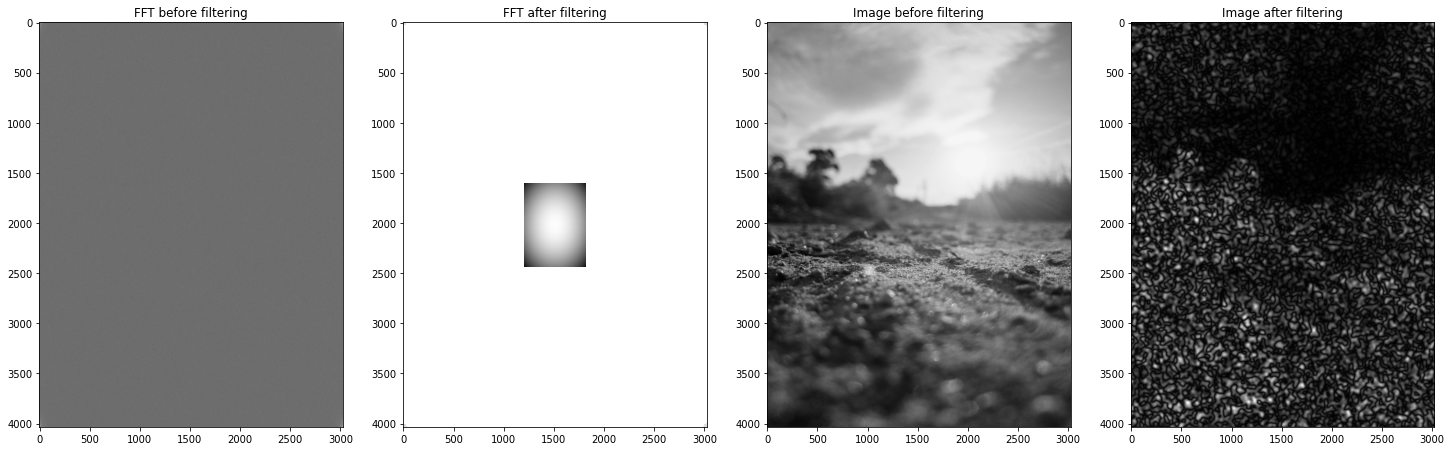

In [ ]:
# apply gaussian filter
gaussian_filt = fourier_gaussian(img_fourier, sigma = 15)
filtered_img = ifft2(gaussian_filt)
gaussian_img = np.abs(filtered_img)

img_fft = 20*np.log(np.abs(fftshift(img_fourier)))
gaussian_filt = 20*np.log(np.abs(fftshift(gaussian_filt)))

plot_fourier(img_fft, gaussian_filt, img_gray, gaussian_img)

Speckle noise removal

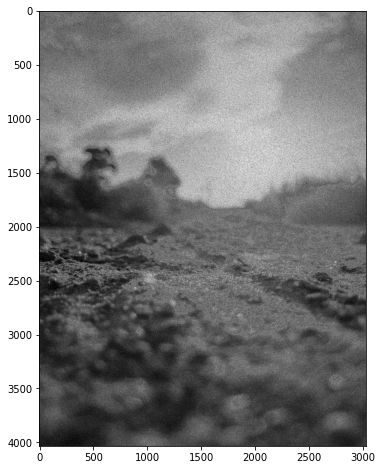

In [ ]:
# speckle noise
gauss = np.random.normal(0,1,img_gray.size)
gauss = gauss.reshape(img_gray.shape[0],img_gray.shape[1]).astype('uint8')

noise = img_gray + img_gray * gauss

# Display the image
plt.figure(figsize=(15, 8))
plt.imshow(noise, cmap='gray')

Poisson noise removal

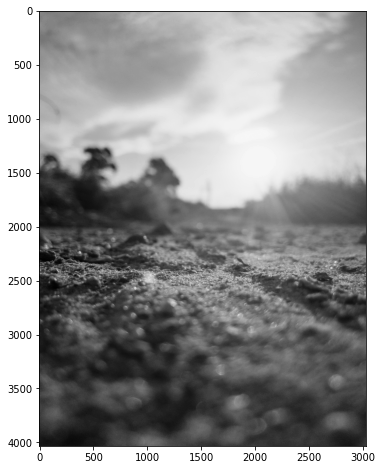

In [ ]:
# poisson noise
vals = len(np.unique(img_gray))
vals = 2 ** np.ceil(np.log2(vals))
noisy = np.random.poisson(img_gray * vals) / float(vals)

# display noisy image
plt.figure(figsize=(15, 8))
plt.imshow(noisy, cmap='gray')

Salt and pepper noise removal

In [ ]:
# salt and pepper noise
def salt_and_pepper(image, amount = 0.004):
  row,col = image.shape
  s_vs_p = 0.5
  out = np.copy(image)
  
  # Salt mode
  num_salt = np.ceil(amount * image.size * s_vs_p)
  coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
  out[coords] = 1
  
  # Pepper mode
  num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
  coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
  out[coords] = 0
  
  return out


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  from ipykernel import kernelapp as app


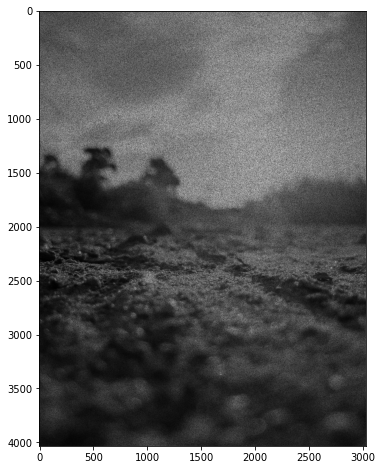

In [ ]:
#display noisy image
noisy_img = salt_and_pepper(img_gray, 0.5)
plt.figure(figsize=(15, 8))
plt.imshow(noisy_img, cmap="gray")

import warnings
warnings.filterwarnings('ignore')

# Others

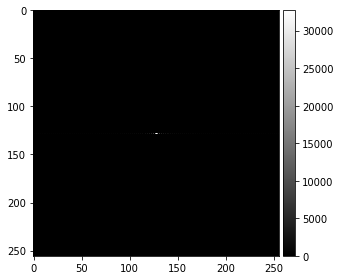

In [ ]:
#Load image
# a sample iimage with a bright center
a= np.hstack([np.zeros((256,128)), np.ones((256,128))])
af= fftshift(fft2(a))
afl= abs(af)
io.imshow(afl, cmap = 'gray')

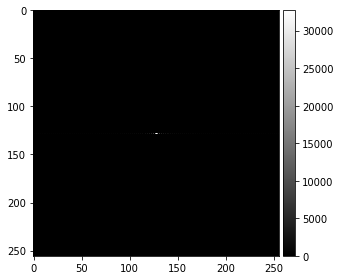

In [ ]:
b= np.hstack([np.ones((256,128)), np.zeros((256,128))])
bf= fftshift(fft2(b))
bf= abs(bf)
io.imshow(bf, cmap='gray')

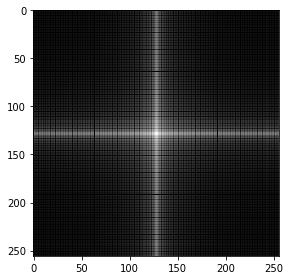

In [ ]:
import skimage.exposure as ex
a=np.zeros((256,256))
a[77:177,77:177]=1
af=fftshift(fft2(a))
afl=ex.rescale_intensity(np.log(1+abs(af)),out_range=(0.0,1.0))
io.imshow(afl)


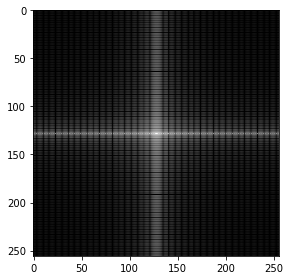

In [ ]:
b[57:157,67:167]=1
bf=fftshift(fft2(b))
bfl=ex.rescale_intensity(np.log(1+abs(bf)),out_range=(0.0,1.0))
io.imshow(bfl)

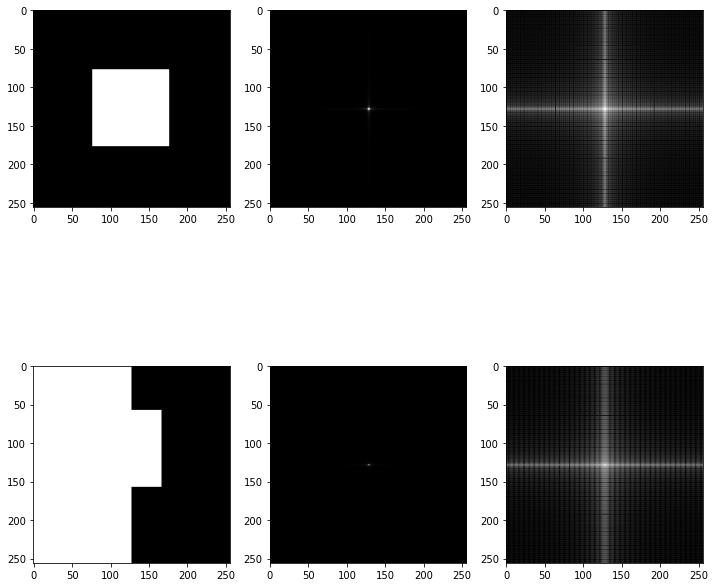

In [ ]:
fig, axs = plt.subplots(2, 3, figsize = (12, 12))
axs[0, 0].imshow(a, cmap = 'gray')
axs[0, 1].imshow(abs(af), cmap = 'gray')
axs[0, 2].imshow(afl, cmap = 'gray')
axs[1, 0].imshow(b, cmap = 'gray')
axs[1, 1].imshow(abs(bf), cmap = 'gray')
axs[1, 2].imshow(bfl, cmap = 'gray')

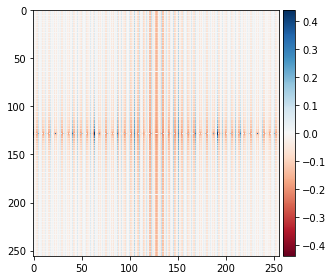

In [ ]:
# compute the difference between the fourier transform
c = bfl - afl
io.imshow(c)

In [ ]:
# verify the invertibility of the FFT


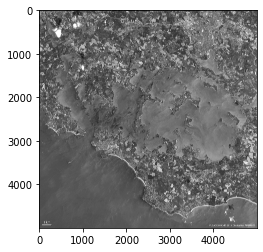

In [ ]:
# Load an image
from skimage import color, exposure, transform
from skimage.color import rgb2gray

img = io.imread("/content/drive/MyDrive/UBS/Computer Vision/Data/em_golfe_du_morbihan_20130603.jpg")
grey_img = rgb2gray(img)
plt.imshow(grey_img, cmap="gray")


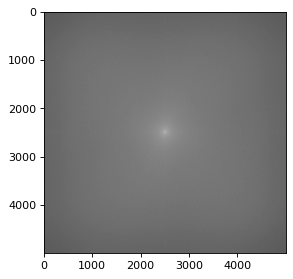

In [ ]:
# f_shift
grey_img_fourier = fftshift(fft2(grey_img))
abs_fourier = abs(grey_img_fourier)

plt.figure(num=None, dpi=80)
plt.imshow(np.log(abs_fourier), cmap='gray')


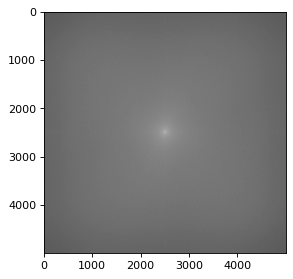

In [ ]:
# compute the inverse discrete fourier transform
img_inv_fourier = fftshift(ifft2(grey_img))
abs_inv_fourier = abs(img_inv_fourier)

plt.figure(num=None, dpi=80)
plt.imshow(np.log(abs_inv_fourier), cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


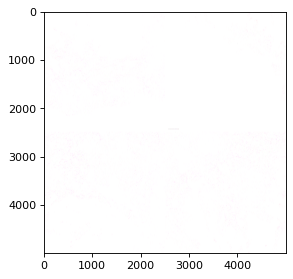

In [ ]:
# Verify the invertibility of the FFT
inverse = ifft2(fft2(img))
inverse_fourier = abs(fftshift(inverse))

plt.figure(num=None, dpi=80)
plt.imshow(np.log(inverse_fourier), cmap='gray')